d:\proiecte cc++\github\uni-ml-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9368 - loss: 0.1522 - val_accuracy: 0.9732 - val_loss: 0.0679
Epoch 2/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9721 - loss: 0.0707 - val_accuracy: 0.9733 - val_loss: 0.0675
Epoch 3/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9725 - loss: 0.0697 - val_accuracy: 0.9734 - val_loss: 0.0673
Epoch 4/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9724 - loss: 0.0703 - val_accuracy: 0.9734 - val_loss: 0.0674
Epoch 5/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9725 - loss: 0.0700 - val_accuracy: 0.9734 - val_loss: 0.0674
Epoch 6/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9727 - loss: 0.0691 - val_accuracy: 0.9734 - val_loss: 0.0675
5847/5847 ━━━━━━━━━━━━━━━━━━━━ 5s 875us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    181501
           1       0.66      0.19      0.3

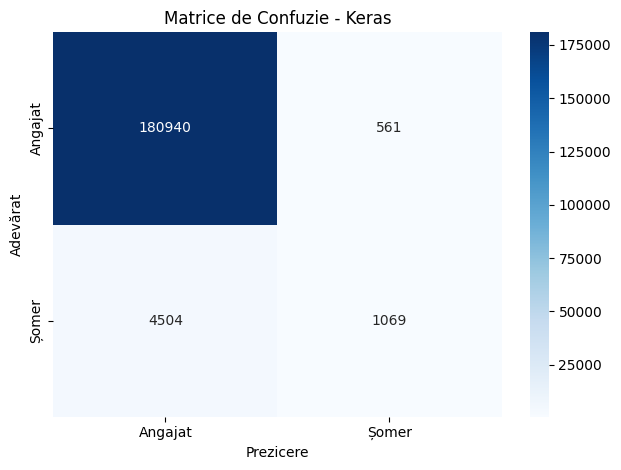

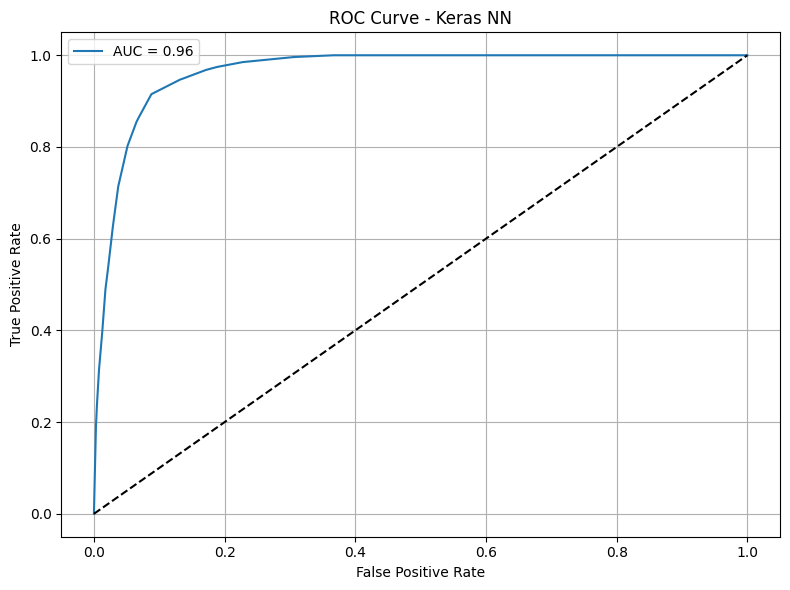

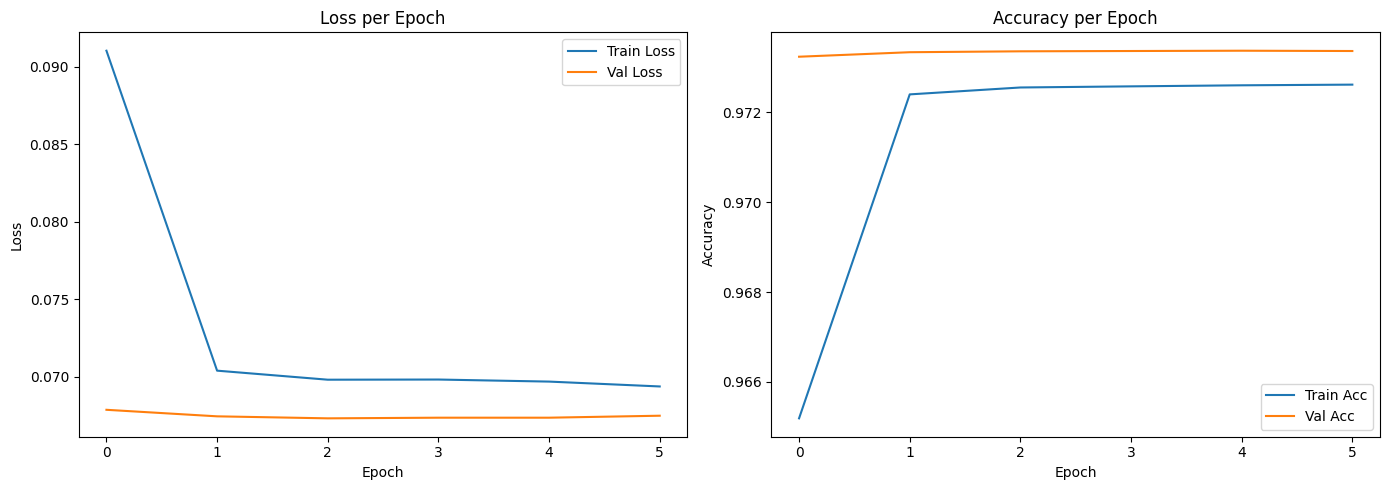

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Încarcă datele ===
dfs = []
for year in ['2010', '2011', '2012', '2013']:
    df = pd.read_csv(f"../data/raw/RO_LFS_{year}_Y.csv", low_memory=False)
    df['YEAR'] = int(year)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# === 2. Prelucrare ===
features = ['SEX', 'AGE', 'EDUCSTAT', 'DEGURBA', 'STAPRO', 'TEMP', 'FTPT', 'COURATT']
target = 'ILOSTAT'

data = data[features + [target]].copy()
data = data[data[target].notna()]
data[target] = (data[target] == 2).astype(int)
data.dropna(subset=features + [target], inplace=True)
data_encoded = pd.get_dummies(data, columns=features, drop_first=True)

# === 3. Split și normalizare ===
X = data_encoded.drop(columns=[target])
y = data_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 4. Construiește modelul Keras ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === 5. Early stopping ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# === 6. Antrenează modelul ===
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# === 7. Predicții și evaluare ===
y_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# === 8. Classification report & Confusion matrix ===
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Angajat", "Șomer"], yticklabels=["Angajat", "Șomer"])
plt.title("Matrice de Confuzie - Keras")
plt.ylabel("Adevărat")
plt.xlabel("Prezicere")
plt.tight_layout()
plt.show()

# === 9. ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Keras NN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 10. Plot loss & accuracy curves ===
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
